In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import os
import fnmatch
import cv2
import numpy as np
import string
import time
import json
from matplotlib import pyplot as plt
# make sure we use tensorflow 2.0
import tensorflow as tf
print(tf.__version__)

# import padding library
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import our model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2.3.0


In [ ]:
current_directory_path = pathlib.Path('/content/drive/My Drive/hackathon_20')
current_directory_path

PosixPath('/content/drive/My Drive/hackathon 20')

In [ ]:
# DATA_PATH = os.path.join(str(current_directory_path), "data")
TEST_FOLDER = os.path.join(current_directory_path, "test")
TRAIN_FOLDER = os.path.join(current_directory_path, "train")

In [ ]:
# checking if GPU is available 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
PATH_LABEL_TRAIN_FOLDER = os.path.join(TRAIN_FOLDER,'labels.json')
with open(PATH_LABEL_TRAIN_FOLDER,encoding="utf8") as json_file:
    dict_label_train = json.load(json_file)

In [ ]:
PATH_LABEL_TEST_FOLDER = os.path.join(TEST_FOLDER,'labels.json')
with open(PATH_LABEL_TEST_FOLDER,encoding="utf8") as json_file:
    dict_label_test = json.load(json_file)

In [ ]:
for k in dict_label_train.keys():
    char_list.update(set(dict_label_train[k]))
for k in dict_label_test.keys():
    char_list.update(set(dict_label_test[k]))
char_list = sorted(char_list)

In [ ]:
# find the maximum label length
label_lens = []
for label in dict_label_train.values():
    label_lens.append(len(label))
for label in dict_label_test.values():
    label_lens.append(len(label))
max_label_len = max(label_lens)
print(max_label_len)

69

In [ ]:
def encode_to_labels(txt):
    # encoding each output word into digits of indexes
    dig_lst = []
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print("No found in char_list :", char)
        
    return dig_lst

In [ ]:
# testing our encode function (text to number)
encode_to_labels("Đồng Nai")

[90, 121, 57, 51, 0, 34, 46, 53]

In [ ]:
# all possible image paths for training
train_image_paths = list(dict_label_train.keys())
test_image_paths = list(dict_label_test.keys())

In [ ]:
train_image_paths = [os.path.join(TRAIN_FOLDER, i) for i in train_image_paths]
test_image_paths = [os.path.join(TEST_FOLDER, i) for i in test_image_paths]

In [ ]:
print("Training images: {}".format(len(train_image_paths)))
print("Testing images: {}".format(len(test_image_paths)))

Training images: 1823
Testing images: 549


In [ ]:
widths = []
heights = []
for image_path in train_image_paths:
    img = cv2.imread(image_path)
    (height, width, _) = img.shape
    heights.append(height)
    widths.append(width)
for image_path in test_image_paths:
    img = cv2.imread(image_path)
    (height, width, _) = img.shape
    heights.append(height)
    widths.append(width)

In [ ]:
min_height = min(heights)
max_height = max(heights)
min_width = min(widths)
max_width = max(widths)

In [ ]:
# this information is useful for making decision for padding and resizing
(min_height, max_height, min_width, max_width)

(91, 118, 1662, 1912)

In [ ]:
def resize_image_by_cv2(img):
    (height, width) = img.shape
    top = (max_height - height) // 2
    bottom = (max_height - height) - (max_height - height) // 2
    left = (max_width - width) // 2
    right = (max_width - width) - (max_width - width) // 2
    color = [255, 255, 0]
    new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
    value=color)
    plt.imshow(new_im)
    plt.show()

In [ ]:
def resize_image_by_np(img):
    (height, width) = img.shape
    top = (max_height - height) // 2
    bottom = (max_height - height) - (max_height - height) // 2
    left = (max_width - width) // 2
    right = (max_width - width) - (max_width - width) // 2
    new_im = np.pad(img, ((top, bottom), (left, right)), 'edge')
    return new_im

In [ ]:
test = cv2.cvtColor(cv2.imread(train_image_paths[1]), cv2.COLOR_BGR2GRAY)

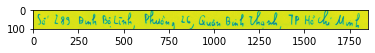

(102, 1852)

In [ ]:
plt.imshow(test)
plt.show()
test.shape

In [ ]:
new = resize_image_by_np(test)

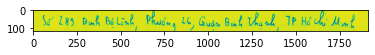

(118, 1912)

In [ ]:
plt.imshow(new)
plt.show()
new.shape

In [ ]:
TIME_STEPS = 239

In [ ]:
# BUILD THE PIPELINE FOR THE IMAGES, definitely this is super basic pipeline and can be improved

# lists for training dataset
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []

i=0
for train_img_path in train_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(train_img_path), cv2.COLOR_BGR2GRAY)

    # resize image.
    img = resize_image_by_np(img)
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_label_train[os.path.basename(train_img_path)]

    # split data into validation and training dataset as 10% and 90% respectively
    orig_txt.append(label)   
    train_label_length.append(len(label))

    # our time steps for valid input
    train_input_length.append(TIME_STEPS)
    training_img.append(img)

    # convert words to digits based on charlist
    training_txt.append(encode_to_labels(label)) 
    i+=1
    if (i%200 == 0):
        print ("has processed trained {} files".format(i))

has processed trained 200 files
has processed trained 400 files
has processed trained 600 files
has processed trained 800 files
has processed trained 1000 files
has processed trained 1200 files
has processed trained 1400 files
has processed trained 1600 files
has processed trained 1800 files


In [ ]:
#lists for validation dataset
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []

i=0

for test_img_path in test_image_paths:
    # print(f_name)
    # read input image and convert into gray scale image
    img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2GRAY)
    
    # resize image.
    img = resize_image_by_np(img)
    
    # add channel dimension
    img = np.expand_dims(img , axis = 2)
    
    # Normalize each image
    img = img/255.

    label = dict_label_test[os.path.basename(test_img_path)]

    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))

    # our time steps for valid input
    valid_input_length.append(TIME_STEPS)
    valid_img.append(img)

    # convert words to digits based on charlist
    valid_txt.append(encode_to_labels(label))
    i+=1
    if (i%200 == 0):
        print ("has processed test {} files".format(i))

has processed test 200 files
has processed test 400 files


In [ ]:
# this is the most controversial part when our max_label_len should be set different or slightly smaller than TIME_STEPS
# but let stick to the conventional/normal way: we should to be the same with our TIME_STEPS
max_label_len = TIME_STEPS

In [ ]:
# pad each output label to maximum text length, remember we did that so that we keep training with rnn consistent?
train_padded_txt = pad_sequences(training_txt, maxlen=max_label_len, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen=max_label_len, padding='post', value = 0)

## Model Building

In [ ]:
# OUR FULL MODEL OF CRNN AND LSTM

# input with shape of height=118 and width=1912 
inputs = Input(shape=(118,1912,1))
 
# convolution layer with kernel size (3,3)  #(118,1912,64)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(59,956,64)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

#(59,956,128)
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)

# pooling layer with kernel size (2,2) to make the height/2 and width/2  #(29,478,128)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

#(29,478,256)
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

# poolig layer with kernel size (2,2) to make the height/2 and width/2  #(14,239,256)
pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

batch_norm_3 = BatchNormalization()(pool_3)

#(14,239,256)
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(batch_norm_3)
# poolig layer with kernel size (2,1) to make the height/2  #(7,239,256)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

# Batch normalization layer #(7,239,256)
batch_norm_4 = BatchNormalization()(pool_4)

#(7,239,512)
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_4)

batch_norm_5 = BatchNormalization()(conv_5)

# pooling layer with kernel size (3,1) to make the height/3 #(2,239,512)
pool_5 = MaxPool2D(pool_size=(3, 1))(batch_norm_5)

#(2,239,512)
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_5)
batch_norm_6 = BatchNormalization()(conv_6)

# pooling layer with kernel size (2,1) to make the height/2 #(1,239,512)
pool_7 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

# # to remove the first dimension of one: (1,239,512) -> (239,512)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(pool_7)
 
# # # bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

# # this is our softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time

act_model = Model(inputs, outputs)

In [ ]:
# define the label input shape for ctc
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')

"""
where input_length and label_length are constants you created previously
the easiest way here is to have a fixed batch size in training 
the lengths should have the same batch size (see shapes in the link for ctc_cost)   
"""

# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
 
# define a ctc lambda function to take arguments and return ctc_bach_cost
# def ctc_lambda_func(args):
#     y_pred, labels, input_length, label_length = args
#     """
#     labels: tensor (number of samples, max_string_length) containing the truth labels.
#     y_pred: tensor (number of samples, time_steps, num_character_labels) containing the prediction, or output of the softmax.
#     input_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_pred.
#     label_length: tensor (number of samples, 1) containing the sequence length for each batch item in y_true.
#     """
#     return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# # out loss function (just take the inputs and put it in our ctc_batch_cost)
# loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
 
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
# ready ctc loss function and optimizers
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
#callback
callback = ModelCheckpoint(
        filepath='mymodel_{epoch}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        save_best_only=True,
        monitor='val_loss',
        verbose=1)

In [ ]:
# ready our training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  # all must be equal length to T timesteps
train_label_length = np.array(train_label_length)  # different length (only the same in Captcha dataset)

# ready our test data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) # all must be equal length to T timesteps
valid_label_length = np.array(valid_label_length) # different length (only the same in Captcha dataset)

In [ ]:
batch_size = 32
epochs = 100

model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, callbacks = callback)

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 26.7227
Epoch 00001: val_loss did not improve from 202.55452
57/57 [==============================] - 31s 549ms/step - loss: 26.7227 - val_loss: 258.3732
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 20.3141
Epoch 00002: val_loss did not improve from 202.55452
57/57 [==============================] - 31s 536ms/step - loss: 20.3141 - val_loss: 336.2943
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 15.3506
Epoch 00003: val_loss did not improve from 202.55452
57/57 [==============================] - 30s 534ms/step - loss: 15.3506 - val_loss: 213.8777
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 12.0813
Epoch 00004: val_loss did not improve from 202.55452
57/57 [==============================] - 31s 535ms/step - loss: 12.0813 - val_loss: 226.5598
Epoch 5/100
57/57 [==============================] - ETA: 0s - loss: 9.9027
Epoch 00005: val_loss improved f

In [ ]:
# save our model
model.save('lastest_model.h5')

In [ ]:
# load the saved best model weights
act_model.load_weights('lastest_model.h5')

In [ ]:
# predict outputs on validation images
NO_PREDICTS = 200
OFFSET=0
prediction = act_model.predict(valid_img[OFFSET:OFFSET+NO_PREDICTS])
#prediction = act_model.predict(valid_img)

In [ ]:
valid_img.shape

(549, 118, 1912, 1)

In [ ]:
# NO_PREDICTS image results
# 9 timesteps
# 32 chars + 1 blank
prediction.shape

(200, 239, 143)

In [ ]:
# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])
 
# see the results
all_predictions =[]
i = 0
for x in out:
    print("original_text  = ", valid_orig_txt[i+OFFSET])
    print("predicted text = ", end = '')
    pred = ""
    for p in x:  
        if int(p) != -1:
            pred += char_list[int(p)]
    print(pred)
    all_predictions.append(pred)
    i+=1

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
original_text  =  Số 10, đường Lý Văn Lâm, Phường 1, Thành Phố Cà Mau, Cà Mau
predicted text = Số 10, đường Lý Văn Lâm, Phường 1, Thành Phố Cà Mau, Cà Mau
original_text  =  271 Huỳnh Ngọc Huệ, Phường Hoà Khê, Quận Thanh Khê, Đà Nẵng
predicted text = 271 Huỳnh Ngọc Huệ, Phường Hà Khê, Quận Thanh Khê, Đà Nẵng
original_text  =  Số 35/70B, KP 9, Phường Hố Nai, Thành Phố Biên Hoà, Đồng Nai
predicted text = Số 35/3B, KP 9, Phường Hố Nai, Thành Phố Bân Hoà, Đồng Nai
original_text  =  Số 187, tổ 8, ấp Tân Hòa, Xã Tân Tiến, Huyện Bù Đốp, Bình Phước
predicted text = Số P, Hố 8, ấ Tân Hoà, Xã Tần Tin, Huyện Bà Đốp, Bình ước
original_text  =  Số 47, tổ 2D, khu 1, Phường Gia Cẩm, Thành phố Việt Trì, Phú Thọ
predicted text = Số 47, tổ 2B Khu I, Phường3 Gia Cẩi, Thành phố Lệt Tì, Ph Thọ
original_text  =  Thôn Cầu Đen, Xã Thanh Xuân, Huyện Sóc Sơn, Hà Nội
predicted text = Tân Cầu Đau, Xã Thanh Xun, Huyện

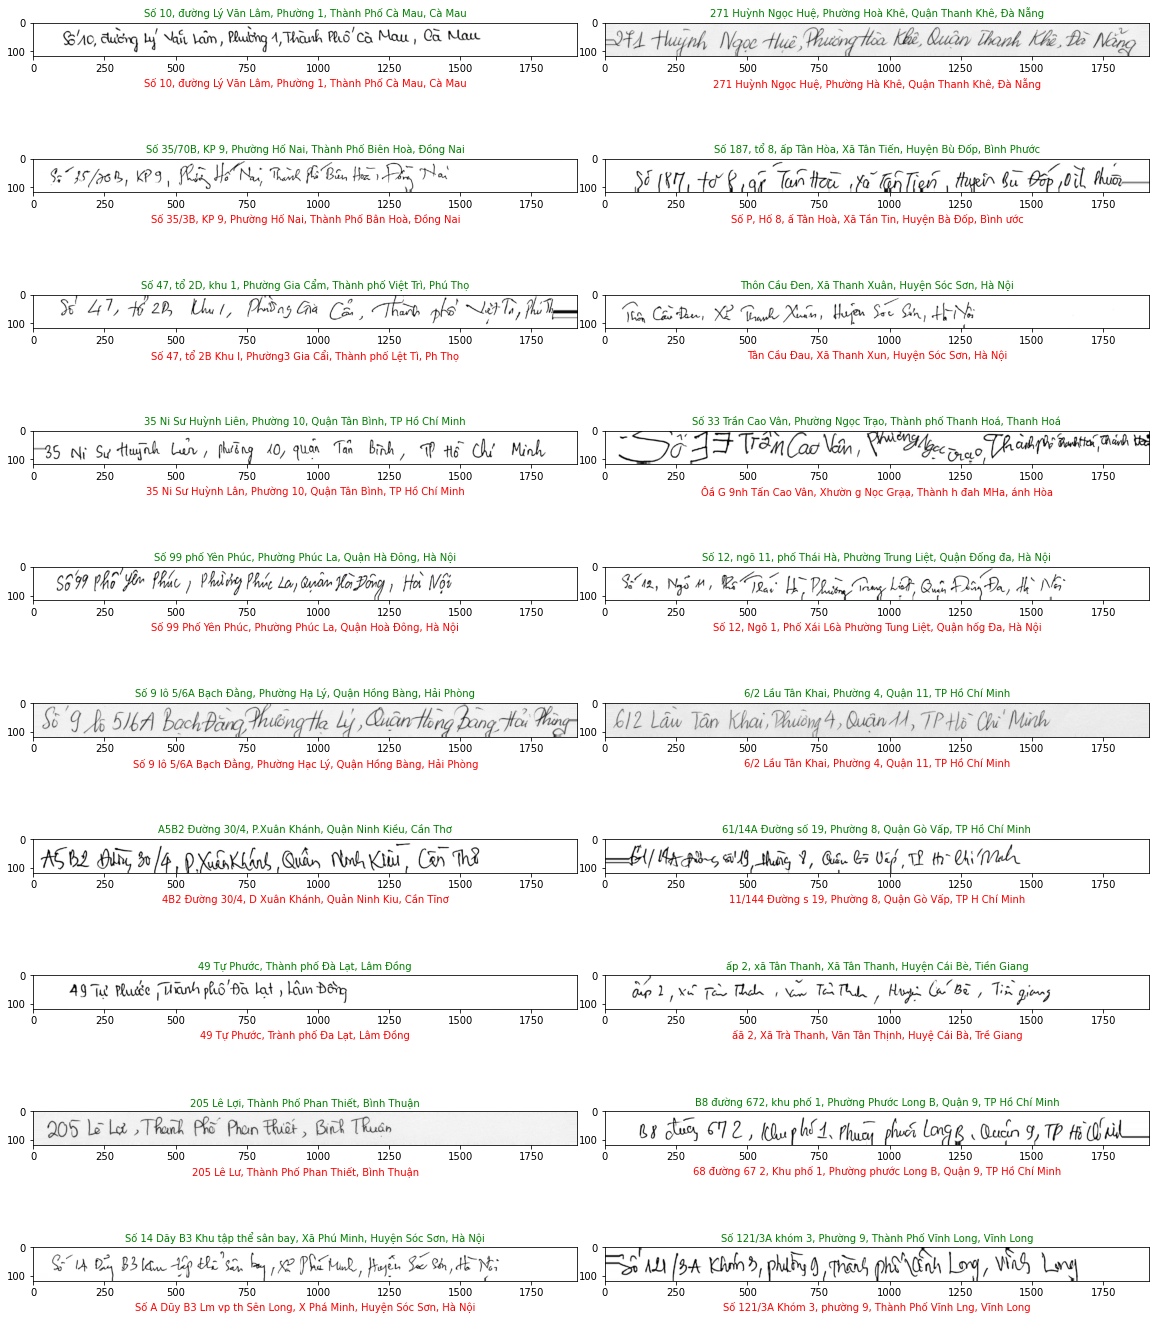

In [ ]:
#YOUR PART: WRITE TO PRINT OUT THE IMAGES IN NICE 2D ARRAY PLOT WITH ORIGINAL TEXT AND PREDICTED TEXT 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.figure(figsize=(20,100))
col=0
row=1
gs1 = gridspec.GridSpec(NO_PREDICTS//5, 2)
gs1.update(wspace=0.05, hspace=0.05)
for n in range(NO_PREDICTS//10):
    plt.subplot(gs1[n])
    plt.title(valid_orig_txt[n+OFFSET], fontsize=10, color="green")
    plt.imshow(valid_img[n][:,:,0], cmap="gray")
    plt.xlabel(all_predictions[n+OFFSET], fontsize=10, color="red")

## Evaluation using CER, WER and SER

In [ ]:
import string
import unicodedata
import editdistance


def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)

In [ ]:
evaluate = ocr_metrics(predicts=all_predictions,
                                  ground_truth=valid_orig_txt,
                                  norm_accentuation=False,
                                  norm_punctuation=False)

e_corpus = "\n".join([
    "Metrics:",
    "Character Error Rate: {}".format(evaluate[0]),
    "Word Error Rate:      {}".format(evaluate[1]),
    "Sequence Error Rate:  {}".format(evaluate[2]),
])

In [ ]:
print(e_corpus)

Metrics:
Character Error Rate: 0.08355677239461531
Word Error Rate:      0.24610360309625035
Sequence Error Rate:  0.905
